In [99]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# PetFinder Competition

Steps to complete: 

+ Load in the data $\checkmark$
+ Peliminary exploration of features in the train $\checkmark$
+ Decide on a train test split for validation 
+ Run an initial model to get a baseline
+ Explore the descriptions turning them into features
+ Apply some feature engineering 
+ Read around about ML approaches that typically work well 
+ Explore the features in the sentiment analysis 
+ Explore the features in the metadata 
+ Consider incorporating learning directly from the images 




Lets start with some imports 

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_loc = "Data/"
train = "train/train.csv"
train_imgs = "train_images"
train_meta = "train_metadata"
train_sentiment = "train_sentiment"

test = "test/test.csv"
test_imgs = "test_imgaes"
test_met = "test_meta"
test_sentiment = "test_sentiment"

breed_labels = "breed_labels.csv"

In [3]:
train_data = pd.read_csv(data_loc + train)
test_data = pd.read_csv(data_loc + test)


The number of rows and columns: 

In [4]:
print('train rows: {}, cols : {}'.format(train_data.shape[0], train_data.shape[1]))
print('test rows: {}, cols : {}'.format(test_data.shape[0], test_data.shape[1]))


train rows: 14993, cols : 24
test rows: 3948, cols : 23


# Exploration 

Some notes to update as we explore 

* The train is 54% dogs, whereas the test is 47% dogs 
* Cats tend to be adopted faster than dogs
* Both cats and dogs tend to be sent in around 4 months with more variation with dogs
* In the test set dogs are sent in slightly older whereas cats age distribution is the same
* Both cats and dogs follow a similar trend as expected where older animals are likely to take longer to be re-homed. A noticable difference is that the instant rehomes for dogs occurs with a wider range than cats, which tend to be very young
* Common cat breeds are domestic short, medium and long as well as tabby in both train and test
* There does seem to be a variation between the breeds and the time to be adopted, so we should utilise this adding the mean and std time for a breed
* Dogs seem to be almost all mixed breeds with labradors coming in a far second, followed by shih tzu, with the train and test being similar
* As with the cat breeds, there are some dogs breeds that are rehomed quicker than others, mixed breeds do particularlly poorly
* 60% of dogs are just one breed and 75% of cats, although it doesn't look like there is much difference in the adoption times if they do have 2 breeds. In fact for cats, it seems to be a boon. This is probably because if they are a commmon type such as a tabby, there is no need to list a second, meaning mixed breed cats are more desireable
* The majority of both cats and dogs are female with males being the second most dominant gender, suprisingly there are lots of group cats
* Train Male dog : 0.36%, Female dog : 0.52%, Group dog : 0.10%, similar dist in test
* Train Male cat : 0.36% , Female cat : 0.44% , Group cat : 0.19%, similar dist in test 
* Male cats tend to get adopted within 3 months whereas there is no sex patterns for dogs 
* The maturity size is well balanced, train vs test for cats and dogs, with the large majority of dogs being type 2, whereas for cats, although type 2 is the most prevalent there are also a sizable amount of type 1s
* A maturity size of small for dogs results often in a quicker adoption, for cats the maturity size doesn't matter so much, as long as it isn't really large (4) which takes a longer time to rehome 
* The majority of dogs are vaccinated whereas cats are not
* Being vaccinated aids in dogs chances of being adopted quicker but suprisingly the opposite is true for cats 
* There are some extreme fees for cats in the test that are not in the train, with the max being > 2000 whereas with dogs we have the opposite problem, where some in the train are very large but the test very small
* Further inspection using binning finds that the dogs fees are quite different in the tests than the train, where the most common found are above 140-250 compared with 50-100 for the train. The cats train more closely follows the test.
* For dogs, it looks like an increase in adoption time as fees increase up to 100, then a sharp decline indicating perhaps rarer dogs
* For cats, the picture is a constent increase in adoption waiting times as the fees increase
* The large majority for dogs and cats train and test are just one animal, although there are some with quite a few more 
* For cats and dogs there is a slight decrease in adoption speeds as the number of animals increases
* Both cats and dogs follow the similar trend, train and test, where shortest hair are the most common and longest the least 
* For both cats and dogs, longer hair results most often in faster adoption rates 
* Health has the expected effect where the less healthy take longer to place, we see similar train test splits 
* Being sterilised doesn't have a large impact on the time to be placed. A slight preference in unsterilised for both cats and dogs.
* For dogs and cats there are similar distributions of states. The large majority are from state '41326' and '41401' and only a few from the others 
* For dogs, these two states offer no big differences in adoption time. 
* For cats state '41326' decreases the likelihood of really long waiting times for adoption 
* For dogs and cats there is a similar distribution between the train and tests for 'color1' with the most frequent being colour 1, black  for cats and for dogs there is a close split between black and brown
* For dogs, the rarer color1,  5 Cream 6 Gray 7 White, reduces the time to adoption. For cats, there is no noticeable advantage of any colour  
* For colour2, the dogs follow a similar distribution as colour1 except there are alot of instances of 7 white, as the secondary colour 
* For cats colour2, there is a much broader distribution of colours. 7 White is the most popular, then black, brown, gray. 
* For cats colour2 the test has a higher proportion of brown than the train has, slightly at least 
* For cats colour2, there isn't a massive difference between the adoption times except for 4 yellow, which sees a longer wait for adoption 
* For dogs colour2, there is no big differences between the adoption times except for 6 grey which sees a much faster adoption time 
* For dogs and cats colour3 is mostly black with a few white, meaning that one could assume black is selected for no colour? 
* For dogs colour3 as yellow increases the time till adoption, all the rest of the colours make little difference 
* For cats colour3 golden and yelllow increase the time for adoption, the rest are around the same time
* PhotoAmt, there is a consistent tailing off of number of photos for both dog and cat. The most frequent is 1 for dogs. For cats the most frequent is 3.
* There is a slight discrepancy between the train and test for both dogs and cats which might need to be looked at further 
* There is a decline in adoption speed for those with more photos up to 5, then a steadying, then large flucutations with larger number of photos. 
* Having no photo is consistently bad for adoption times 
* There are mostly no vidoes for both cats and dogs then a few with one or two and a couple of outliers with up to 9 videos 
* Some of the training expamples have 8 videos for dogs whereas the test only has up to five
* Conversely, the test set has some examples with 9 videos for cats whereas the training data has only up to 6 
* Having one or two videos for cats means that it will less likely take a long time to be adopted. More than 2 videos in fact increases the amount of time to be adopted on average
* For dogs having up to three videos can decrease the time to adoption but any more than that has too much variance so this needs to be bagged 


# Feature Engineering ideas

  gather general breed information 
  categorise rare breeds
  add breed mean and std time to adoption
  

Features to explore

In [5]:
list(train_data)

['Type',
 'Name',
 'Age',
 'Breed1',
 'Breed2',
 'Gender',
 'Color1',
 'Color2',
 'Color3',
 'MaturitySize',
 'FurLength',
 'Vaccinated',
 'Dewormed',
 'Sterilized',
 'Health',
 'Quantity',
 'Fee',
 'State',
 'RescuerID',
 'VideoAmt',
 'Description',
 'PetID',
 'PhotoAmt',
 'AdoptionSpeed']

## Type 

Type corresponds to the animal type, where dog = 1 and cat = 2

We can see below there is skewing of the types, where the train contains more dogs and the test more cats

Dog train percent: 0.5423864470086041 Dog test percent: 0.47391084093211755 


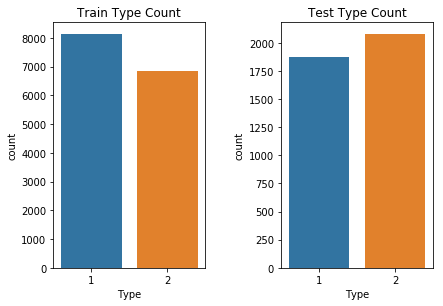

In [6]:
f, axis = plt.subplots(1,2)
f.tight_layout()
f.subplots_adjust(wspace = 0.5)
train_type_plot = sns.countplot(x = 'Type', data = train_data, ax = axis[0])
train_type_plot.set_title('Train Type Count')
test_type_plot = sns.countplot(x = 'Type', data = test_data, ax = axis[1])
test_type_plot.set_title('Test Type Count')

dog_train = train_data[train_data['Type'] == 1]
cat_train = train_data[train_data['Type'] == 2]
dog_percent_train = (train_data['Type'] == 1).sum() / train_data.shape[0]
cat_percent_train = (train_data['Type'] == 2).sum() / train_data.shape[0]

dog_percent_test = (test_data['Type'] == 1).sum() / test_data.shape[0]
cat_percent_test = (test_data['Type'] == 2).sum() / test_data.shape[0]


print('Dog train percent: {} Dog test percent: {} '.format(dog_percent_train, dog_percent_test))

## Adoption speed reference 

0. Pet was adopted on the same day as it was listed. 
1. Within one week 
2. Within one month 
3. Within three months
4. Not adopted

Text(0.5, 1.0, 'Dogs v Cat Adoption Speed')

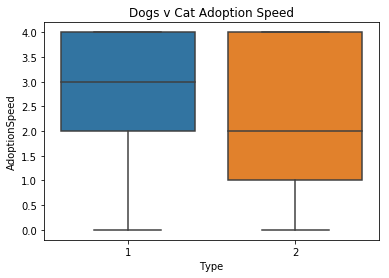

In [7]:
box_plot_cats_v_dog = sns.boxplot(train_data['Type'], train_data['AdoptionSpeed'])
box_plot_cats_v_dog.set_title('Dogs v Cat Adoption Speed')

Text(0.5, 1.0, 'Cat Adoption Dist')

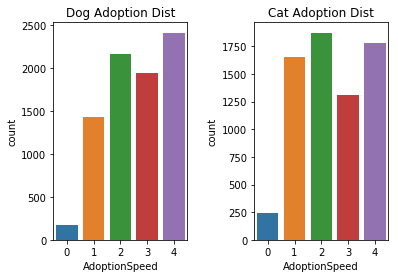

In [8]:
f, ax = plt.subplots(1,2)
f.subplots_adjust(wspace = 0.5)


adoption_speed_dog = sns.countplot(train_data[train_data['Type'] == 1]['AdoptionSpeed'], ax = ax[0])
adoption_speed_dog.set_title('Dog Adoption Dist')

adoption_speed_cat = sns.countplot(train_data[train_data['Type'] == 2]['AdoptionSpeed'], ax = ax[1])
adoption_speed_cat.set_title('Cat Adoption Dist')

So it seems that enjoy a slightly faster adoption speed than cats 

# Age

Text(0.5, 1.0, 'Test - boxplot of age by type')

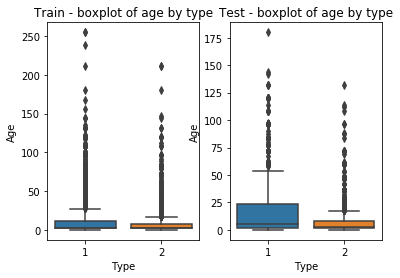

In [9]:
f, ax = plt.subplots(1,2)

both_age_plot_train = sns.boxplot(x = 'Type',y = 'Age',data = train_data, ax = ax[0])
both_age_plot_train.set_title('Train - boxplot of age by type')
both_age_plot_test = sns.boxplot(x = 'Type', y = 'Age', data = test_data, ax = ax[1]) 
both_age_plot_test.set_title('Test - boxplot of age by type')



Text(0.5, 1.0, 'Test - boxplot of age by type \n limited')

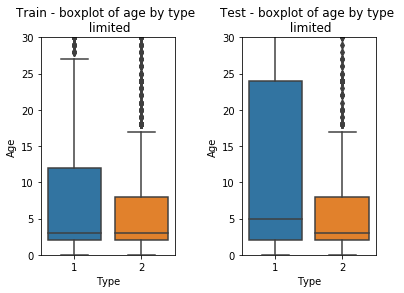

In [10]:
f, ax = plt.subplots(1,2)
f.subplots_adjust(wspace = 0.5)
both_age_plot_train = sns.boxplot(x = 'Type',y = 'Age',data = train_data, ax = ax[0])
ax[0].set_ylim([0, 30])
both_age_plot_train.set_title('Train - boxplot of age by type \n limited')
both_age_plot_test = sns.boxplot(x = 'Type', y = 'Age', data = test_data, ax = ax[1]) 
ax[1].set_ylim([0, 30])
both_age_plot_test.set_title('Test - boxplot of age by type \n limited')

 

Text(0.5, 1.0, 'Cat Age V Adoption Speed')

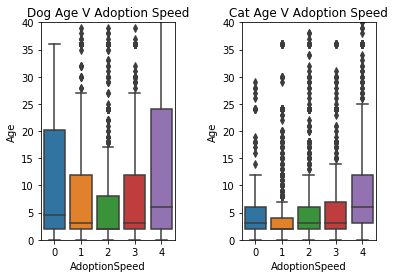

In [11]:
f, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
age_adoption_speed_dog = sns.boxplot(x = 'AdoptionSpeed', y = 'Age', data = dog_train, ax = ax[0])
age_adoption_speed_cat = sns.boxplot(x = 'AdoptionSpeed', y = 'Age', data = cat_train, ax = ax[1])
ax[0].set_ylim([0,40])
ax[1].set_ylim([0,40])

age_adoption_speed_dog.set_title('Dog Age V Adoption Speed')
age_adoption_speed_cat.set_title('Cat Age V Adoption Speed')

# Breed 1

Now lets join the breed names with the breed numbers and have a look at the most popular

In [12]:
breed_label_data = pd.read_csv(data_loc + breed_labels)
breed_one_n = breed_label_data[['BreedID', 'BreedName']].rename(columns = {'BreedID' : 'Breed1', 'BreedName' : 'BreedName1'})
breed_two_n = breed_label_data[['BreedID', 'BreedName']].rename(columns = {'BreedID' : 'Breed2', 'BreedName' : 'BreedName2'})

train_data = train_data.merge(breed_one_n, how = "left", on = "Breed1")
train_data = train_data.merge(breed_two_n, how = "left", on = "Breed2")

test_data = test_data.merge(breed_one_n, how = "left", on = "Breed1")
test_data = test_data.merge(breed_two_n, how = "left", on = "Breed2")



In [13]:
dog_train = train_data[train_data['Type'] == 1]
cat_train = train_data[train_data['Type'] == 2]
dog_test = test_data[test_data['Type'] == 1]
cat_test = test_data[test_data['Type'] == 2]

In [14]:
cat_train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'BreedName1', 'BreedName2'],
      dtype='object')

In [15]:
print('Cat Breeds train:\n' , pd.value_counts(cat_train['BreedName1']))
print('Cat Breeds test:\n' , pd.value_counts(cat_test['BreedName1']))

Cat Breeds train:
 Domestic Short Hair                      3634
Domestic Medium Hair                     1258
Tabby                                     342
Domestic Long Hair                        296
Siamese                                   264
Persian                                   221
Calico                                    105
American Shorthair                         94
Oriental Short Hair                        73
Bengal                                     71
Tuxedo                                     56
Tortoiseshell                              42
Maine Coon                                 34
British Shorthair                          34
Abyssinian                                 28
Russian Blue                               26
Burmese                                    23
Tiger                                      21
Bobtail                                    19
American Curl                              17
Oriental Long Hair                         17
Ragdoll        

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

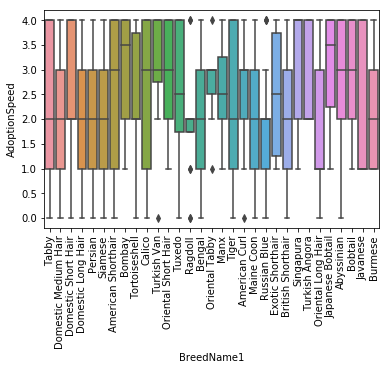

In [16]:
sns.boxplot(x = 'BreedName1', y = 'AdoptionSpeed', data = cat_train.groupby('BreedName1').
             filter(lambda t : len(t) > 5))
plt.xticks(rotation = 90)

In [17]:
print('Dog count train:\n',pd.value_counts(dog_train['BreedName1']))
print('Dog count test:\n',pd.value_counts(dog_test['BreedName1']))

Dog count train:
 Mixed Breed                     5923
Labrador Retriever               205
Shih Tzu                         189
Poodle                           167
Terrier                          161
Golden Retriever                 151
German Shepherd Dog               98
Beagle                            90
Spitz                             89
Rottweiler                        88
Schnauzer                         69
Miniature Pinscher                67
Jack Russell Terrier              64
Doberman Pinscher                 62
Cocker Spaniel                    41
Dalmatian                         39
Chihuahua                         37
Husky                             37
Dachshund                         28
Belgian Shepherd Malinois         26
Border Collie                     26
Siberian Husky                    25
Silky Terrier                     24
Pit Bull Terrier                  23
Pomeranian                        22
Pug                               21
Maltese             

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

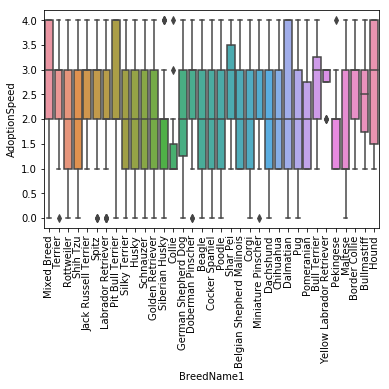

In [18]:
sns.boxplot(x = 'BreedName1', y = 'AdoptionSpeed', data = dog_train.groupby('BreedName1').
           filter(lambda t : len(t) > 10))
plt.xticks(rotation = 90)

Now lets see how many are just one breed and how many are multiple

In [19]:
no_second_breed_dog = dog_train[dog_train.Breed2 == 0]
has_second_breed_dog = dog_train[dog_train.Breed2 != 0]
no_second_breed_cat = cat_train[cat_train.Breed2 == 0]
has_second_breed_cat = cat_train[cat_train.Breed2 != 0]

print('no second breed dog percent {}'.format(no_second_breed_dog.shape[0] / dog_train.shape[0]))
print('no second breed cat percent {}'.format(no_second_breed_cat.shape[0] / cat_train.shape[0]))

no second breed dog percent 0.691957697983276
no second breed cat percent 0.7484331730068503


Text(0.5, 1.0, 'has second breed cat')

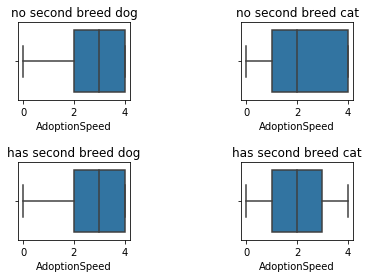

In [20]:
f, axa = plt.subplots(2,2)
f.subplots_adjust(wspace = 1, hspace = 0.8)
no_s_dog_p = sns.boxplot(x = no_second_breed_dog['AdoptionSpeed'], ax = axa[0][0])
has_s_dog_p = sns.boxplot(x = has_second_breed_dog['AdoptionSpeed'], ax = axa[1][0])
no_s_cat_p = sns.boxplot(x = no_second_breed_cat['AdoptionSpeed'], ax = axa[0][1])
has_s_cat_p = sns.boxplot(x = has_second_breed_cat['AdoptionSpeed'], ax = axa[1][1])

no_s_dog_p.set_title('no second breed dog')
has_s_dog_p.set_title('has second breed dog')
no_s_cat_p.set_title('no second breed cat')
has_s_cat_p.set_title('has second breed cat')

# Gender 

Male dog : 0.3695277914412199, Female dog : 0.5228726020659125, Group dog : 0.10759960649286768
Male cat : 0.3688966622941262, Female cat : 0.4408978283049118, Group dog : 0.19020550940096195


Text(0.5, 1.0, 'Cat Gender Test Dist')

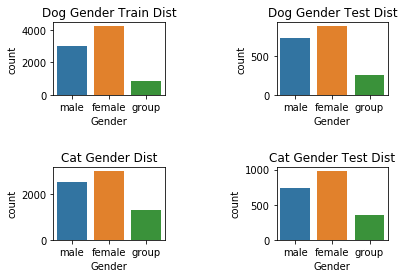

In [21]:
f, ax  = plt.subplots(2,2)
plt.subplots_adjust(wspace = 1, hspace = 1)
dog_gender_breakdown = dog_train.groupby('Gender').apply(lambda x : len(x))
print('Male dog : {}, Female dog : {}, Group dog : {}'.format(
    dog_gender_breakdown[1] / dog_train.shape[0], 
       dog_gender_breakdown[2] / dog_train.shape[0],
      dog_gender_breakdown[3] / dog_train.shape[0]))
cat_gender_breakdown = cat_train.groupby('Gender').apply(lambda x : len(x))
print('Male cat : {}, Female cat : {}, Group dog : {}'.format(
    cat_gender_breakdown[1] / cat_train.shape[0], 
       cat_gender_breakdown[2] / cat_train.shape[0],
      cat_gender_breakdown[3] / cat_train.shape[0]))

dog_gender_count = sns.countplot(x = 'Gender', data = dog_train, ax = ax[0][0])
dog_gender_count.set_xticklabels(('male', 'female', 'group'))
dog_gender_count.set_title('Dog Gender Train Dist')
dog_gender_count = sns.countplot(x = 'Gender', data = dog_test, ax = ax[0][1])
dog_gender_count.set_xticklabels(('male', 'female', 'group'))
dog_gender_count.set_title('Dog Gender Test Dist')

cat_gender_count = sns.countplot(x = 'Gender', data = cat_train, ax = ax[1][0])
cat_gender_count.set_xticklabels(('male', 'female', 'group'))
cat_gender_count.set_title('Cat Gender Dist')
cat_gender_count = sns.countplot(x = 'Gender', data = cat_test, ax = ax[1][1])
cat_gender_count.set_xticklabels(('male', 'female', 'group'))
cat_gender_count.set_title('Cat Gender Test Dist')

[Text(0, 0, 'male'), Text(0, 0, 'female'), Text(0, 0, 'group')]

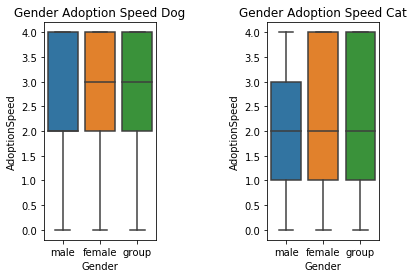

In [22]:
f, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 1)
gender_adop_dog = sns.boxplot(x = 'Gender', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
gender_adop_dog.set_title('Gender Adoption Speed Dog')
gender_adop_dog.set_xticklabels(('male', 'female', 'group'))
gender_adop_cat = sns.boxplot(x = 'Gender', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
gender_adop_cat.set_title('Gender Adoption Speed Cat')
gender_adop_cat.set_xticklabels(('male', 'female', 'group'))

# Maturity Size

Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

[Text(0, 0, 's'), Text(0, 0, 'm'), Text(0, 0, 'l'), Text(0, 0, 'Xl')]

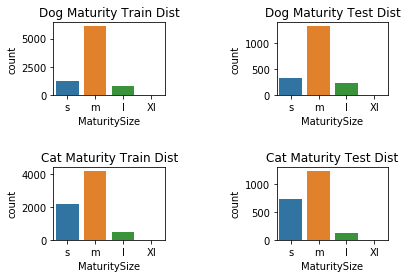

In [23]:
f, ax  = plt.subplots(2,2)
plt.subplots_adjust(wspace = 1, hspace = 1)

maturity_dog_count = sns.countplot(x = 'MaturitySize', data = dog_train, ax = ax[0][0])
maturity_dog_count.set_title('Dog Maturity Train Dist')
maturity_dog_count.set_xticklabels(('s', 'm', 'l', 'Xl'))

maturity_dog_count = sns.countplot(x = 'MaturitySize', data = dog_test, ax = ax[0][1])
maturity_dog_count.set_title('Dog Maturity Test Dist')
maturity_dog_count.set_xticklabels(('s', 'm', 'l', 'Xl'))


maturity_cat_count = sns.countplot(x = 'MaturitySize', data = cat_train, ax = ax[1][0])
maturity_cat_count.set_title('Cat Maturity Train Dist')
maturity_cat_count.set_xticklabels(('s', 'm', 'l', 'Xl'))

maturity_cat_count = sns.countplot(x = 'MaturitySize', data = cat_test, ax = ax[1][1])
maturity_cat_count.set_title('Cat Maturity Test Dist')
maturity_cat_count.set_xticklabels(('s', 'm', 'l', 'Xl'))


[Text(0, 0, 's'), Text(0, 0, 'm'), Text(0, 0, 'l'), Text(0, 0, 'Xl')]

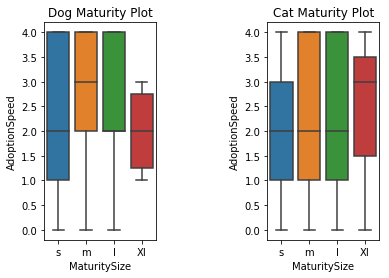

In [24]:
f, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 1)
maturity_dog_plot = sns.boxplot(x = 'MaturitySize', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
maturity_dog_plot.set_title('Dog Maturity Plot')
maturity_dog_plot.set_xticklabels(('s', 'm', 'l', 'Xl'))

maturity_cat_plot = sns.boxplot(x = 'MaturitySize', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
maturity_cat_plot.set_title('Cat Maturity Plot')
maturity_cat_plot.set_xticklabels(('s', 'm', 'l', 'Xl'))

# Vaccinated 

Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

[Text(0, 0, 'y'), Text(0, 0, 'n'), Text(0, 0, '?')]

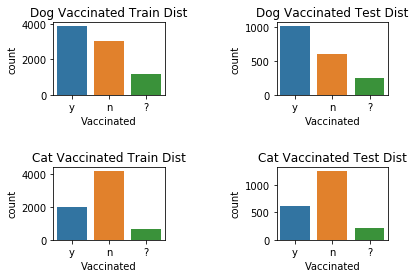

In [25]:
dog_train['Vaccinated']

f, ax  = plt.subplots(2,2)
plt.subplots_adjust(wspace = 1, hspace = 1)

vaccinated_dog_count = sns.countplot(x = 'Vaccinated', data = dog_train, ax = ax[0][0])
vaccinated_dog_count.set_title('Dog Vaccinated Train Dist')
vaccinated_dog_count.set_xticklabels(('y', 'n', '?'))

vaccinated_dog_count = sns.countplot(x = 'Vaccinated', data = dog_test, ax = ax[0][1])
vaccinated_dog_count.set_title('Dog Vaccinated Test Dist')
vaccinated_dog_count.set_xticklabels(('y', 'n', '?'))


vaccinated_cat_count = sns.countplot(x = 'Vaccinated', data = cat_train, ax = ax[1][0])
vaccinated_cat_count.set_title('Cat Vaccinated Train Dist')
vaccinated_cat_count.set_xticklabels(('y', 'n', '?'))

vaccinated_cat_count = sns.countplot(x = 'Vaccinated', data = cat_test, ax = ax[1][1])
vaccinated_cat_count.set_title('Cat Vaccinated Test Dist')
vaccinated_cat_count.set_xticklabels(('y', 'n', '?'))

[Text(0, 0, 'y'), Text(0, 0, 'n'), Text(0, 0, '?')]

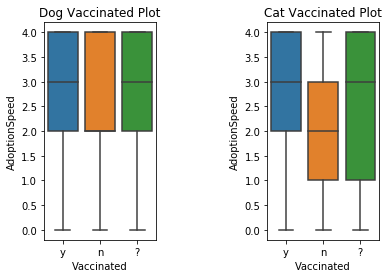

In [26]:
f, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 1)
vaccinated_dog_plot = sns.boxplot(x = 'Vaccinated', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
vaccinated_dog_plot.set_title('Dog Vaccinated Plot')
vaccinated_dog_plot.set_xticklabels(('y', 'n', '?'))

vaccinated_cat_plot = sns.boxplot(x = 'Vaccinated', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
vaccinated_cat_plot.set_title('Cat Vaccinated Plot')
vaccinated_cat_plot.set_xticklabels(('y', 'n', '?'))

# Fee

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'dog test')

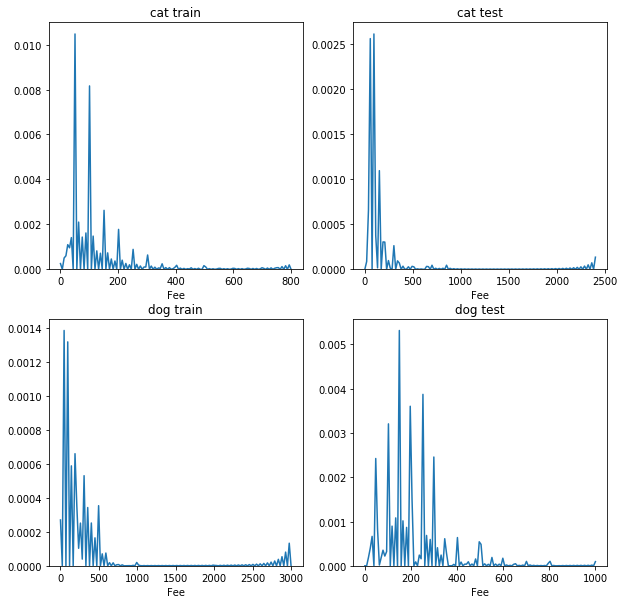

In [27]:
f, ax = plt.subplots(2,2, figsize = (10,10))

cat_tr = sns.distplot(cat_train['Fee'],hist = False, ax = ax[0][0])
cat_tr.set_title('cat train')
cat_te = sns.distplot(cat_test['Fee'],hist = False, ax = ax[0][1])
cat_te.set_title('cat test')
dog_tr = sns.distplot(dog_train['Fee'],hist = False, ax = ax[1][0])
dog_tr.set_title('dog train')
dog_te = sns.distplot(dog_test['Fee'],hist = False, ax = ax[1][1])
dog_te.set_title('dog test')

In [28]:
print('dog train bins: ', pd.value_counts(dog_train['Fee'], bins = 100).iloc[0:10])
print('dog test bins: ', pd.value_counts(dog_test['Fee'], bins = 100).iloc[0:10])


dog train bins:  (-3.001, 30.0]    7156
(30.0, 60.0]       189
(90.0, 120.0]      175
(180.0, 210.0]     162
(270.0, 300.0]      96
(120.0, 150.0]      82
(240.0, 270.0]      61
(60.0, 90.0]        52
(480.0, 510.0]      47
(330.0, 360.0]      39
Name: Fee, dtype: int64
dog test bins:  (-1.001, 10.0]    1524
(190.0, 200.0]      64
(240.0, 250.0]      51
(140.0, 150.0]      49
(90.0, 100.0]       44
(40.0, 50.0]        41
(290.0, 300.0]      24
(490.0, 500.0]      13
(340.0, 350.0]      11
(20.0, 30.0]        10
Name: Fee, dtype: int64


In [29]:
print('cat train bins: ', pd.value_counts(cat_train['Fee'], bins = 100).iloc[0:10])
print('cat test bins: ', pd.value_counts(cat_test['Fee'], bins = 100).iloc[0:10])

cat train bins:  (-0.801, 8.0]     5770
(48.0, 56.0]       298
(96.0, 104.0]      245
(24.0, 32.0]        90
(144.0, 152.0]      80
(8.0, 16.0]         67
(192.0, 200.0]      61
(16.0, 24.0]        37
(248.0, 256.0]      33
(296.0, 304.0]      28
Name: Fee, dtype: int64
cat test bins:  (-2.401, 24.0]    1755
(48.0, 72.0]        98
(96.0, 120.0]       94
(24.0, 48.0]        39
(144.0, 168.0]      34
(192.0, 216.0]      18
(72.0, 96.0]        10
(288.0, 312.0]       8
(336.0, 360.0]       5
(240.0, 264.0]       3
Name: Fee, dtype: int64


E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cat Train Free Vs Adoption')

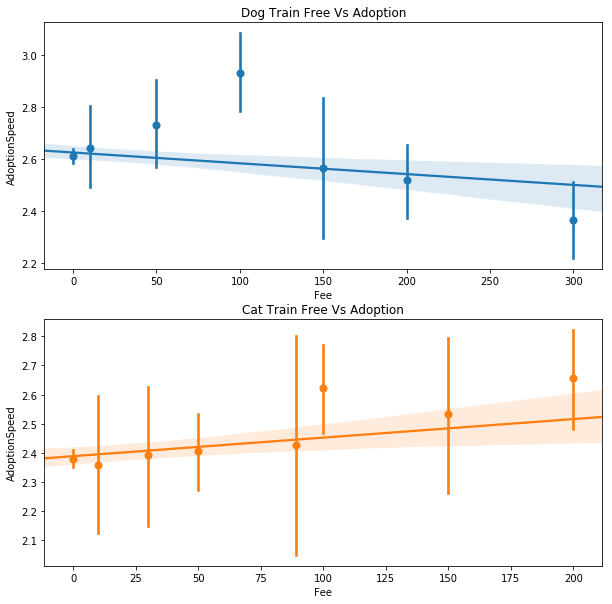

In [98]:
f, ax = plt.subplots(2, figsize =(10,10))

dog_fee_p = sns.regplot(y = 'AdoptionSpeed', x = 'Fee',x_bins = 50, ax = ax[0], data = dog_train)
dog_fee_p.set_title('Dog Train Free Vs Adoption')
cat_fee_p = sns.regplot(y = 'AdoptionSpeed', x = 'Fee', ax = ax[1],x_bins = 50, data = cat_train)
cat_fee_p.set_title('Cat Train Free Vs Adoption')

Text(0.5, 1.0, 'fees across dog breeds')

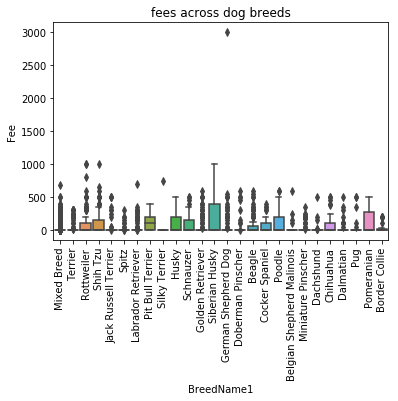

In [31]:
sns.boxplot(x = 'BreedName1', y = 'Fee', data = dog_train.groupby('BreedName1').
           filter(lambda t : len(t) > 20))
plt.xticks(rotation = 90)
plt.title('fees across dog breeds')

Text(0.5, 1.0, 'fees across cat breeds')

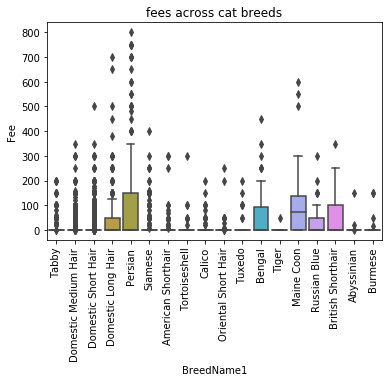

In [32]:
sns.boxplot(x = 'BreedName1', y = 'Fee', data = cat_train.groupby('BreedName1').
           filter(lambda t : len(t) > 20))
plt.xticks(rotation = 90)
plt.title('fees across cat breeds')

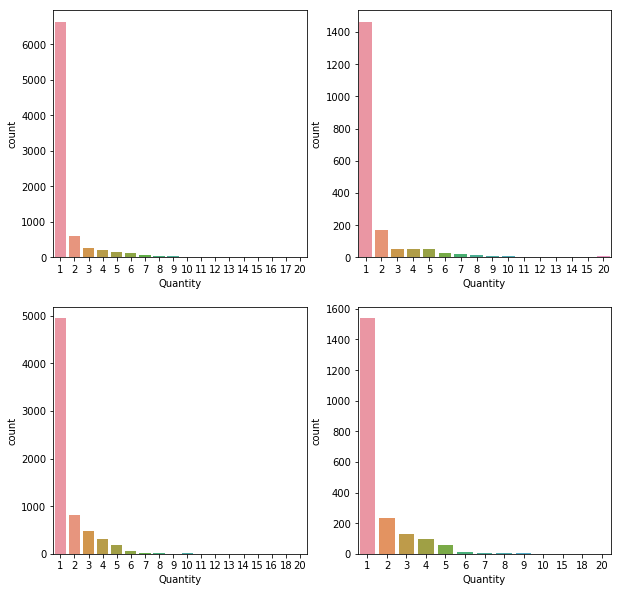

In [33]:
f, ax = plt.subplots(2,2, figsize=(10,10))

sns.countplot(dog_train['Quantity'], ax = ax[0][0])

sns.countplot(dog_test['Quantity'], ax = ax[0][1])

sns.countplot(cat_train['Quantity'], ax = ax[1][0])

sns.countplot(cat_test['Quantity'], ax = ax[1][1])

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cat animial count vs adoption speed')

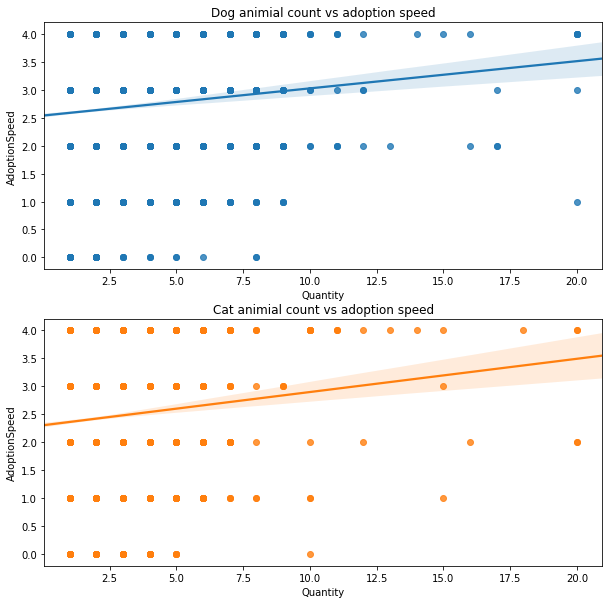

In [34]:
f, ax = plt.subplots(2, figsize=(10,10))

dog_count_ap = sns.regplot(x = 'Quantity', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_count_ap.set_title('Dog animial count vs adoption speed')
cat_count_ap = sns.regplot(x = 'Quantity', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_count_ap.set_title('Cat animial count vs adoption speed')

# Fur Length

Text(0.5, 1.0, 'Cat Test Fur')

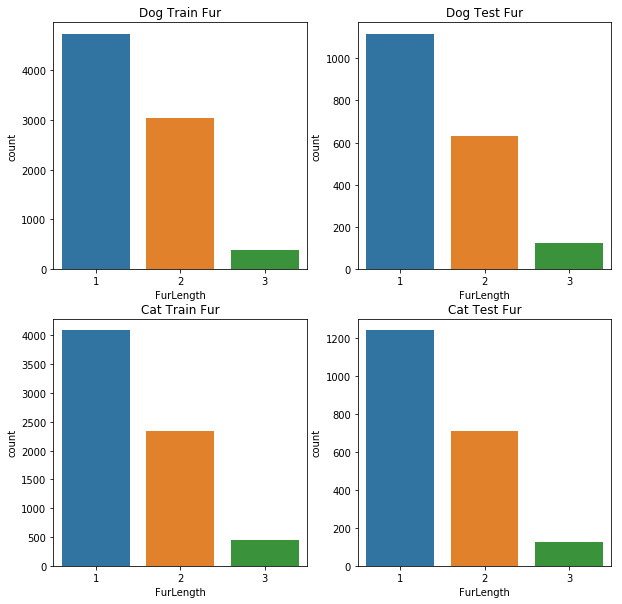

In [35]:
f, ax = plt.subplots(2,2, figsize=(10,10))

dtr_fur = sns.countplot(dog_train['FurLength'], ax = ax[0,0])
dtr_fur.set_title('Dog Train Fur')
dte_fur = sns.countplot(dog_test['FurLength'], ax = ax[0,1])
dte_fur.set_title('Dog Test Fur')
ctr_fur = sns.countplot(cat_train['FurLength'], ax = ax[1,0])
ctr_fur.set_title('Cat Train Fur')
cte_fur = sns.countplot(cat_test['FurLength'], ax = ax[1,1])
cte_fur.set_title('Cat Test Fur')

Text(0.5, 1.0, 'Cat Fur Vs Adoption')

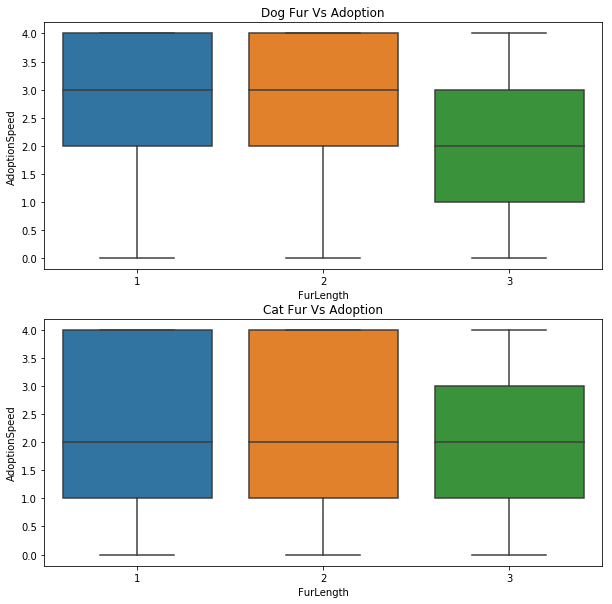

In [36]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_fur = sns.boxplot(x = 'FurLength', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_fur.set_title('Dog Fur Vs Adoption')

cat_fur = sns.boxplot(x = 'FurLength', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_fur.set_title('Cat Fur Vs Adoption')

# Health

Text(0.5, 1.0, 'cat test health')

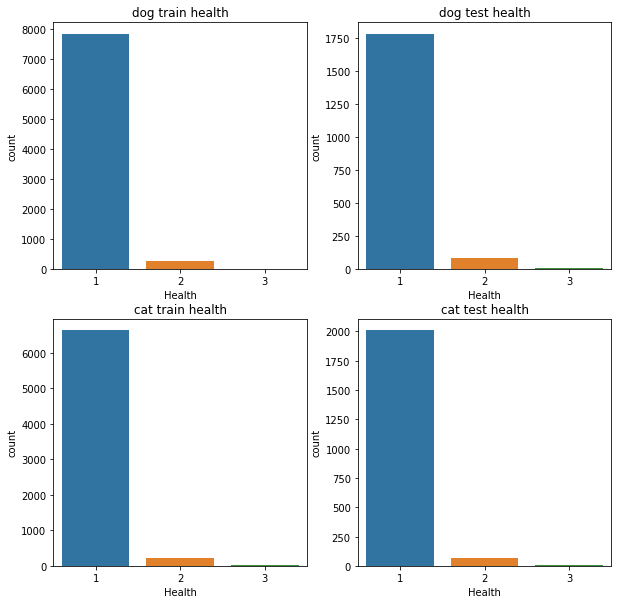

In [46]:
f, ax = plt.subplots(2,2, figsize=(10,10))
dte_h = sns.countplot(dog_train['Health'], ax = ax[0,0])
dte_h.set_title('dog train health')
dte_h = sns.countplot(dog_test['Health'], ax = ax[0,1])
dte_h.set_title('dog test health')
dte_h = sns.countplot(cat_train['Health'], ax = ax[1,0])
dte_h.set_title('cat train health')
dte_h = sns.countplot(cat_test['Health'], ax = ax[1,1])
dte_h.set_title('cat test health')

Text(0.5, 1.0, 'Cat Health Vs Adoption')

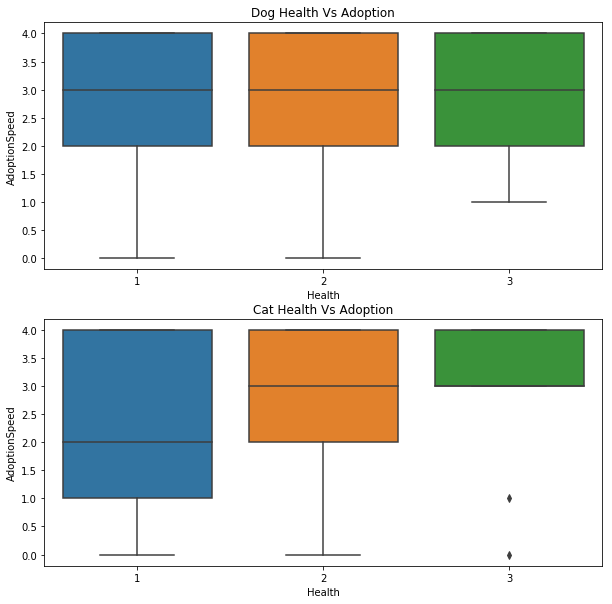

In [49]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_health = sns.boxplot(x = 'Health', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_health.set_title('Dog Health Vs Adoption')

cat_health = sns.boxplot(x = 'Health', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_health.set_title('Cat Health Vs Adoption')

## Sterilised

 Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Text(0.5, 1.0, 'cat test Sterilized')

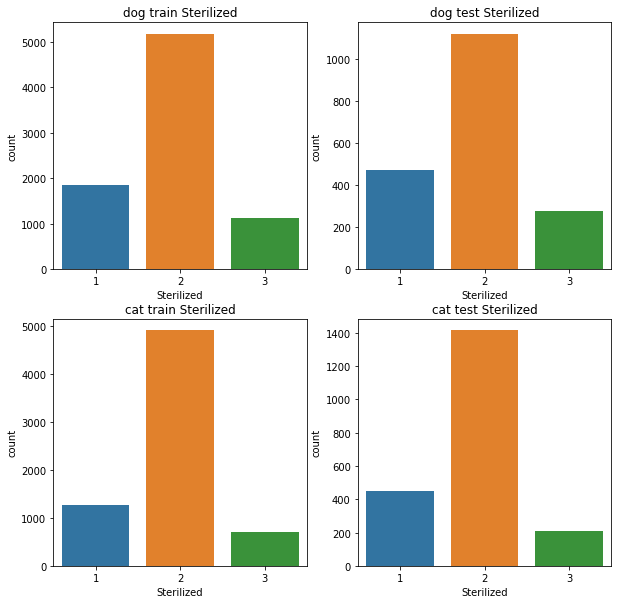

In [51]:
f, ax = plt.subplots(2,2, figsize=(10,10))
dte_h = sns.countplot(dog_train['Sterilized'], ax = ax[0,0])
dte_h.set_title('dog train Sterilized')
dte_h = sns.countplot(dog_test['Sterilized'], ax = ax[0,1])
dte_h.set_title('dog test Sterilized')
dte_h = sns.countplot(cat_train['Sterilized'], ax = ax[1,0])
dte_h.set_title('cat train Sterilized')
dte_h = sns.countplot(cat_test['Sterilized'], ax = ax[1,1])
dte_h.set_title('cat test Sterilized')

Text(0.5, 1.0, 'Cat Sterilized Vs Adoption')

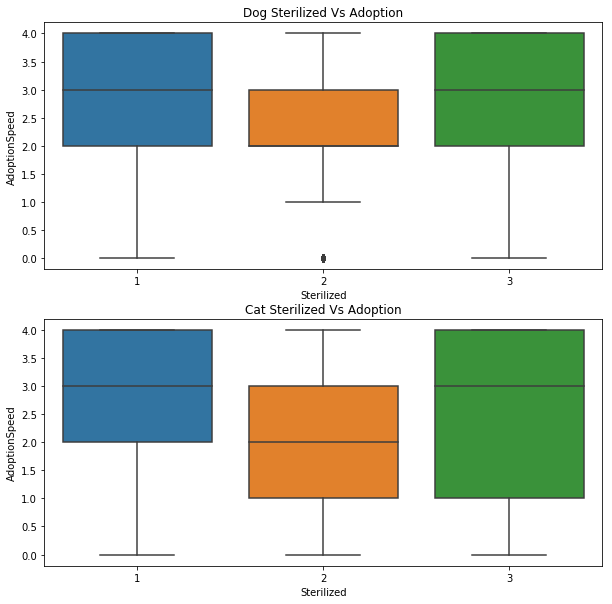

In [56]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.boxplot(x = 'Sterilized', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog Sterilized Vs Adoption')

cat_ster = sns.boxplot(x = 'Sterilized', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat Sterilized Vs Adoption')

## State  

In [59]:
state_labels = pd.read_csv('state_labels.csv')

Text(0.5, 1.0, 'cat test State')

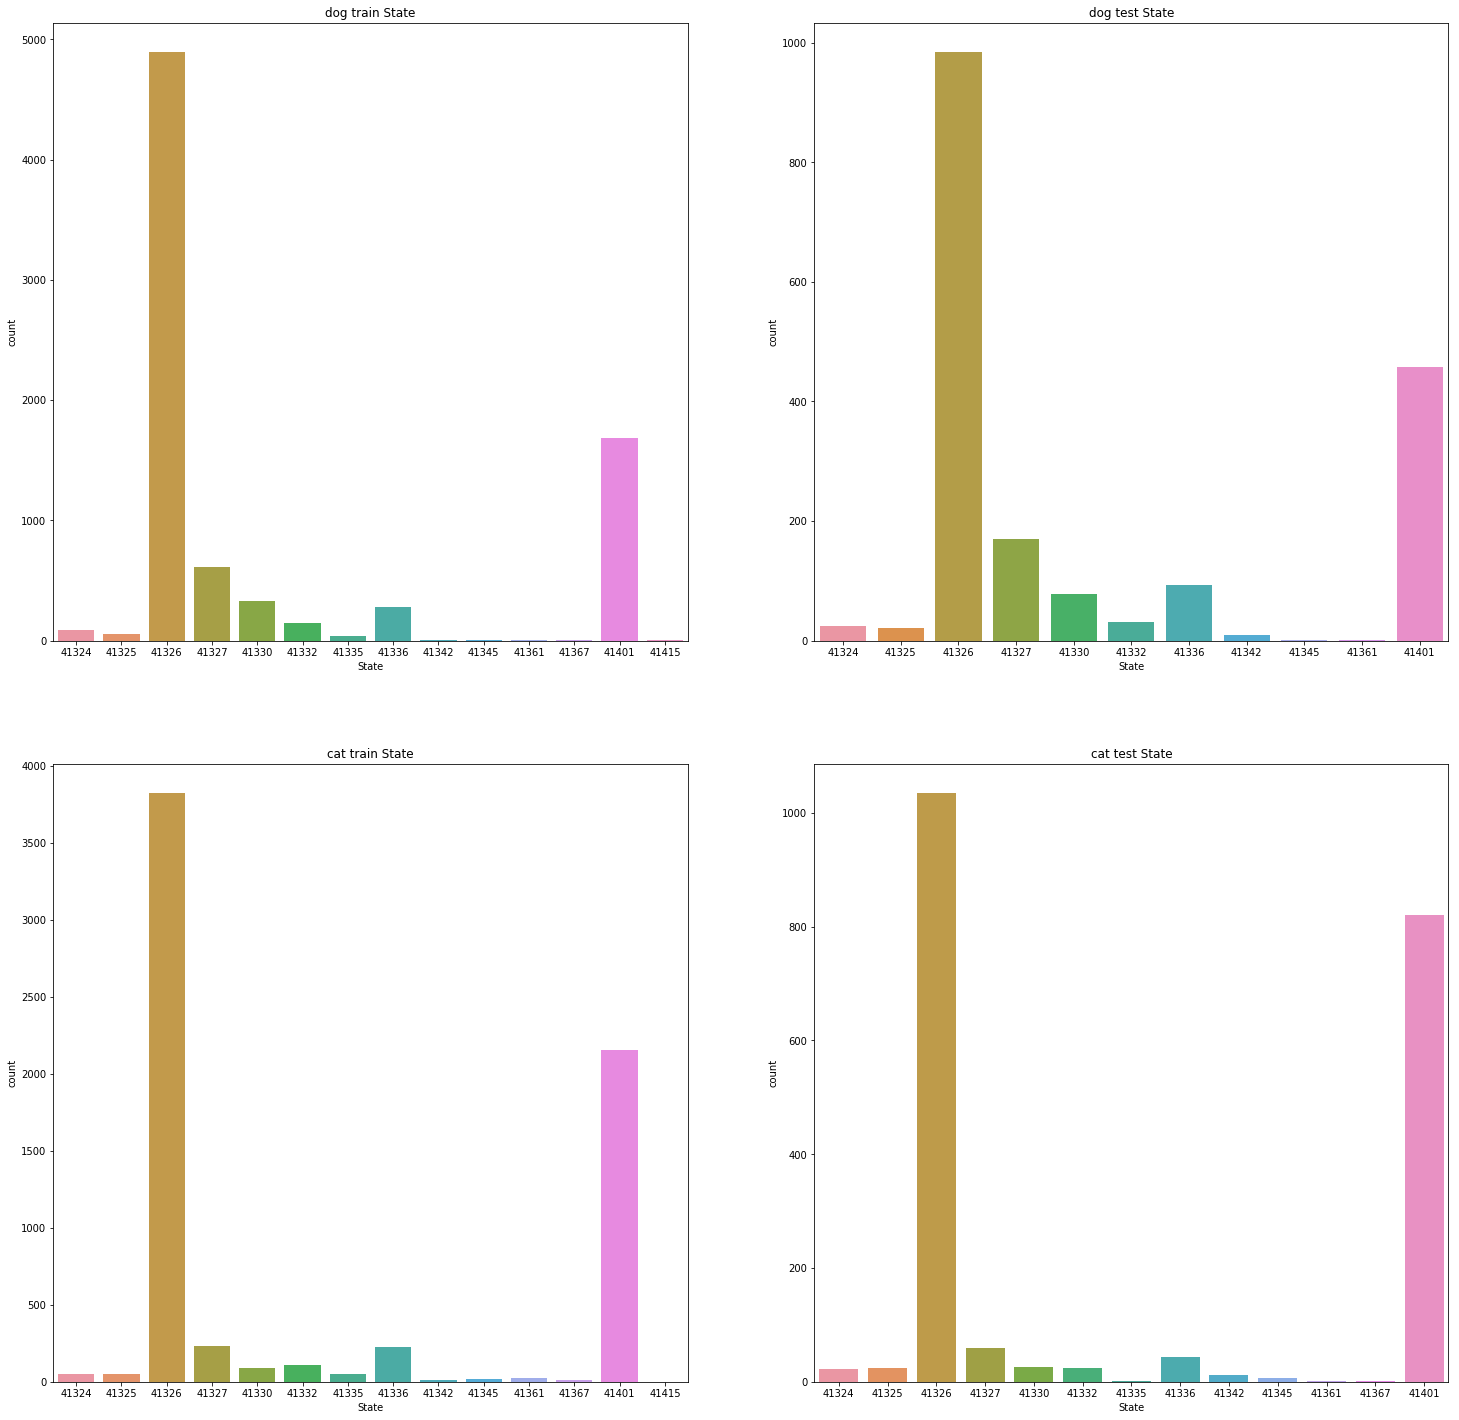

In [65]:
f, ax = plt.subplots(2,2, figsize=(25,25))
dte_h = sns.countplot(dog_train['State'], ax = ax[0,0])
dte_h.set_title('dog train State')
dte_h = sns.countplot(dog_test['State'], ax = ax[0,1])
dte_h.set_title('dog test State')
dte_h = sns.countplot(cat_train['State'], ax = ax[1,0])
dte_h.set_title('cat train State')
dte_h = sns.countplot(cat_test['State'], ax = ax[1,1])
dte_h.set_title('cat test State')

Text(0.5, 1.0, 'Cat State Vs Adoption')

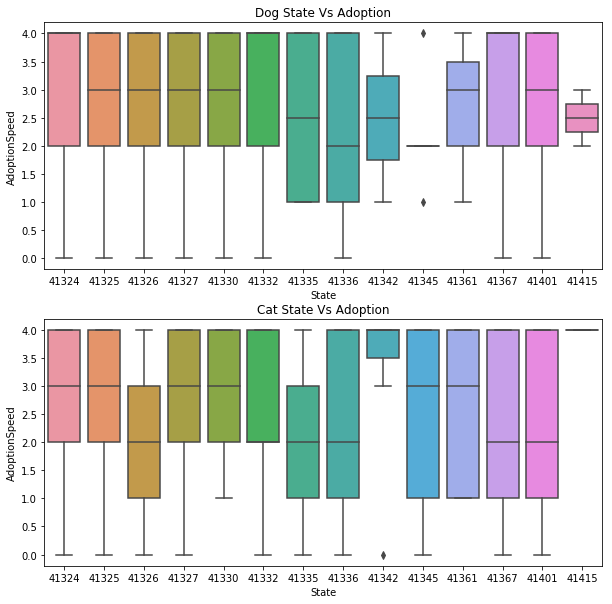

In [66]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.boxplot(x = 'State', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog State Vs Adoption')

cat_ster = sns.boxplot(x = 'State', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat State Vs Adoption')

## Colour 1  

1 	Black
2 	Brown
3 	Golden
4 	Yellow
5 	Cream
6 	Gray
7 	White

In [67]:
colour_labels = pd.read_csv('color_labels.csv')

Text(0.5, 1.0, 'cat test Color1')

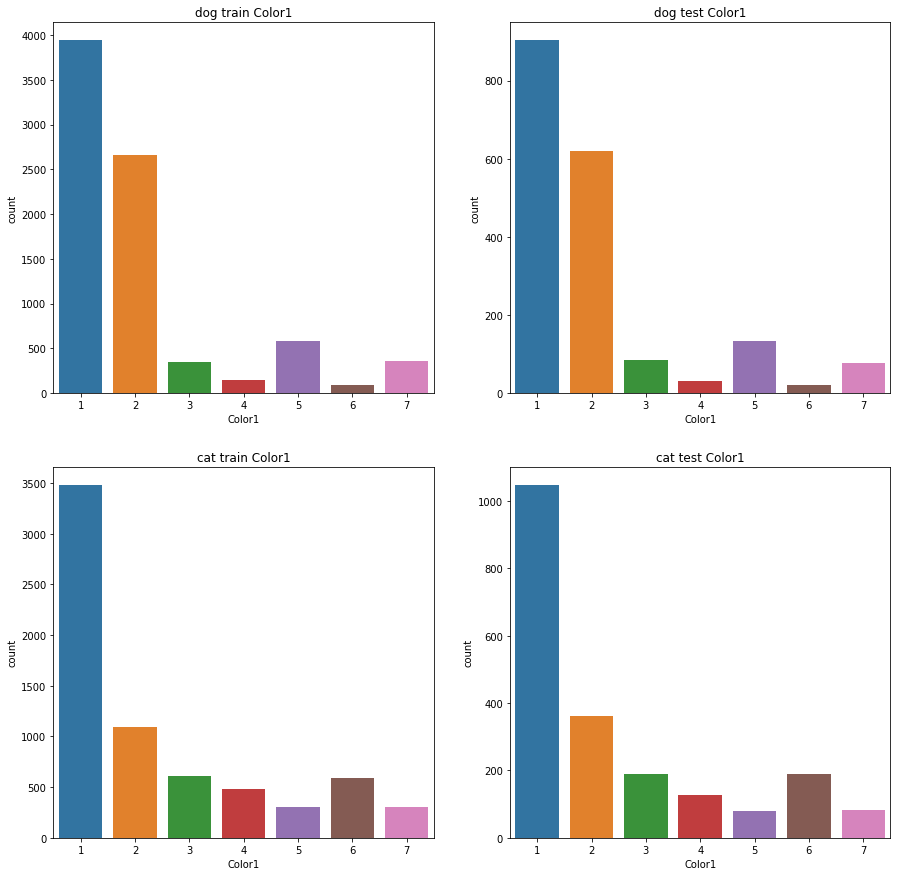

In [72]:
f, ax = plt.subplots(2,2, figsize=(15,15))
dte_h = sns.countplot(dog_train['Color1'], ax = ax[0,0])
dte_h.set_title('dog train Color1')
dte_h = sns.countplot(dog_test['Color1'], ax = ax[0,1])
dte_h.set_title('dog test Color1')
dte_h = sns.countplot(cat_train['Color1'], ax = ax[1,0])
dte_h.set_title('cat train Color1')
dte_h = sns.countplot(cat_test['Color1'], ax = ax[1,1])
dte_h.set_title('cat test Color1')

Text(0.5, 1.0, 'Cat Color1 Vs Adoption')

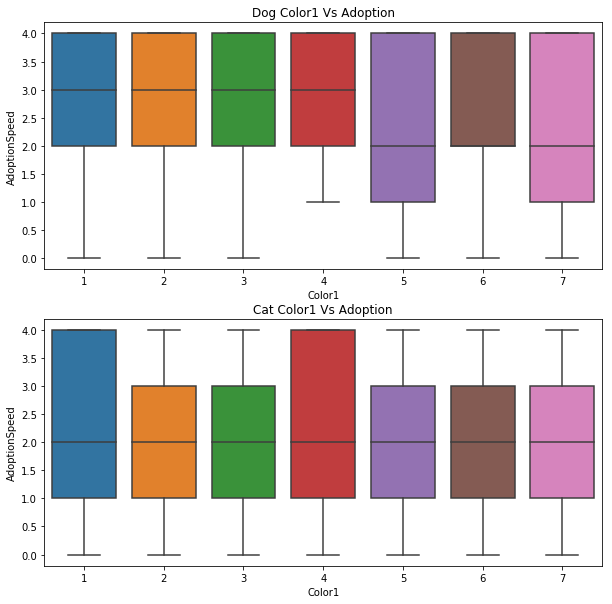

In [71]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.boxplot(x = 'Color1', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog Color1 Vs Adoption')

cat_ster = sns.boxplot(x = 'Color1', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat Color1 Vs Adoption')

## Colour 2

1 Black 2 Brown 3 Golden 4 Yellow 5 Cream 6 Gray 7 White


Text(0.5, 1.0, 'cat test Color2')

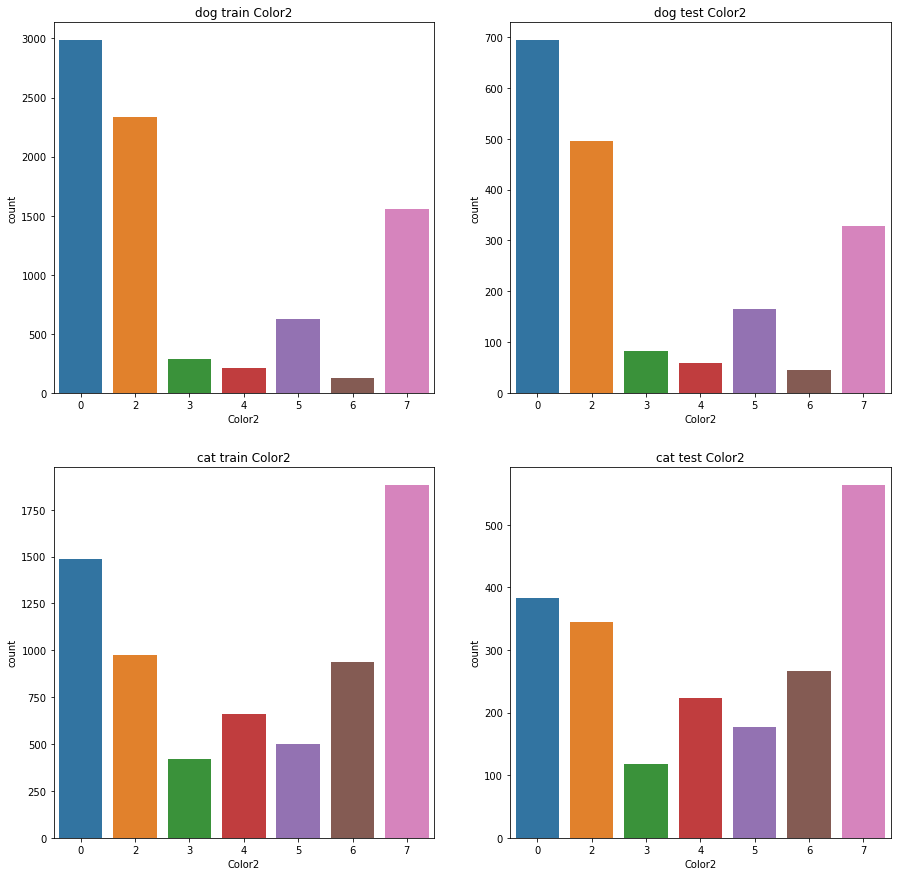

In [73]:
f, ax = plt.subplots(2,2, figsize=(15,15))
dte_h = sns.countplot(dog_train['Color2'], ax = ax[0,0])
dte_h.set_title('dog train Color2')
dte_h = sns.countplot(dog_test['Color2'], ax = ax[0,1])
dte_h.set_title('dog test Color2')
dte_h = sns.countplot(cat_train['Color2'], ax = ax[1,0])
dte_h.set_title('cat train Color2')
dte_h = sns.countplot(cat_test['Color2'], ax = ax[1,1])
dte_h.set_title('cat test Color2')

Text(0.5, 1.0, 'Cat Color2 Vs Adoption')

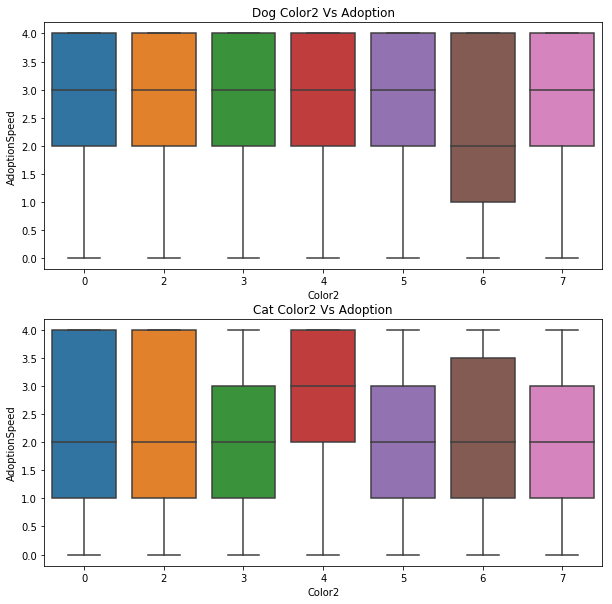

In [74]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.boxplot(x = 'Color2', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog Color2 Vs Adoption')

cat_ster = sns.boxplot(x = 'Color2', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat Color2 Vs Adoption')

## Colour3

1 Black 2 Brown 3 Golden 4 Yellow 5 Cream 6 Gray 7 White

Text(0.5, 1.0, 'cat test Color3')

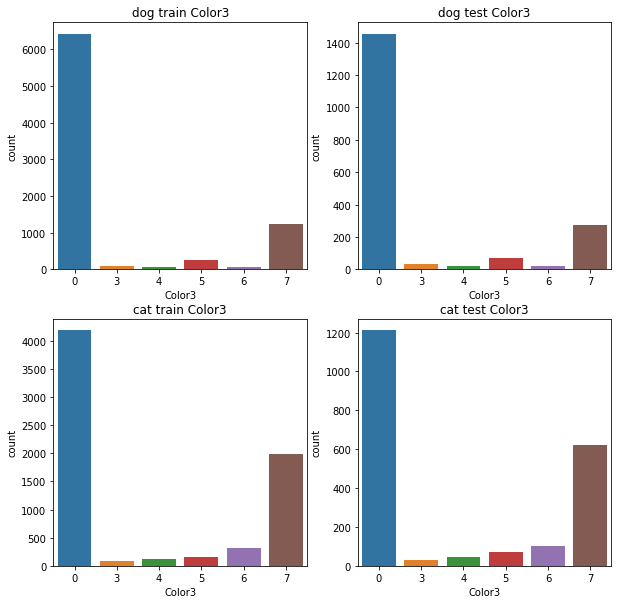

In [76]:
f, ax = plt.subplots(2,2, figsize=(10,10))
dte_h = sns.countplot(dog_train['Color3'], ax = ax[0,0])
dte_h.set_title('dog train Color3')
dte_h = sns.countplot(dog_test['Color3'], ax = ax[0,1])
dte_h.set_title('dog test Color3')
dte_h = sns.countplot(cat_train['Color3'], ax = ax[1,0])
dte_h.set_title('cat train Color3')
dte_h = sns.countplot(cat_test['Color3'], ax = ax[1,1])
dte_h.set_title('cat test Color3')

Text(0.5, 1.0, 'Cat Color3 Vs Adoption')

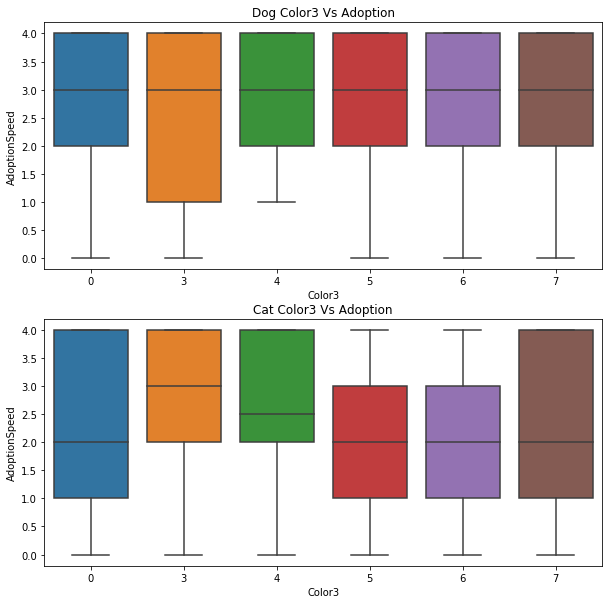

In [77]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.boxplot(x = 'Color3', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog Color3 Vs Adoption')

cat_ster = sns.boxplot(x = 'Color3', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat Color3 Vs Adoption')

## PhotoAmt 


Total uploaded photos for this pet

Text(0.5, 1.0, 'cat test PhotoAmt')

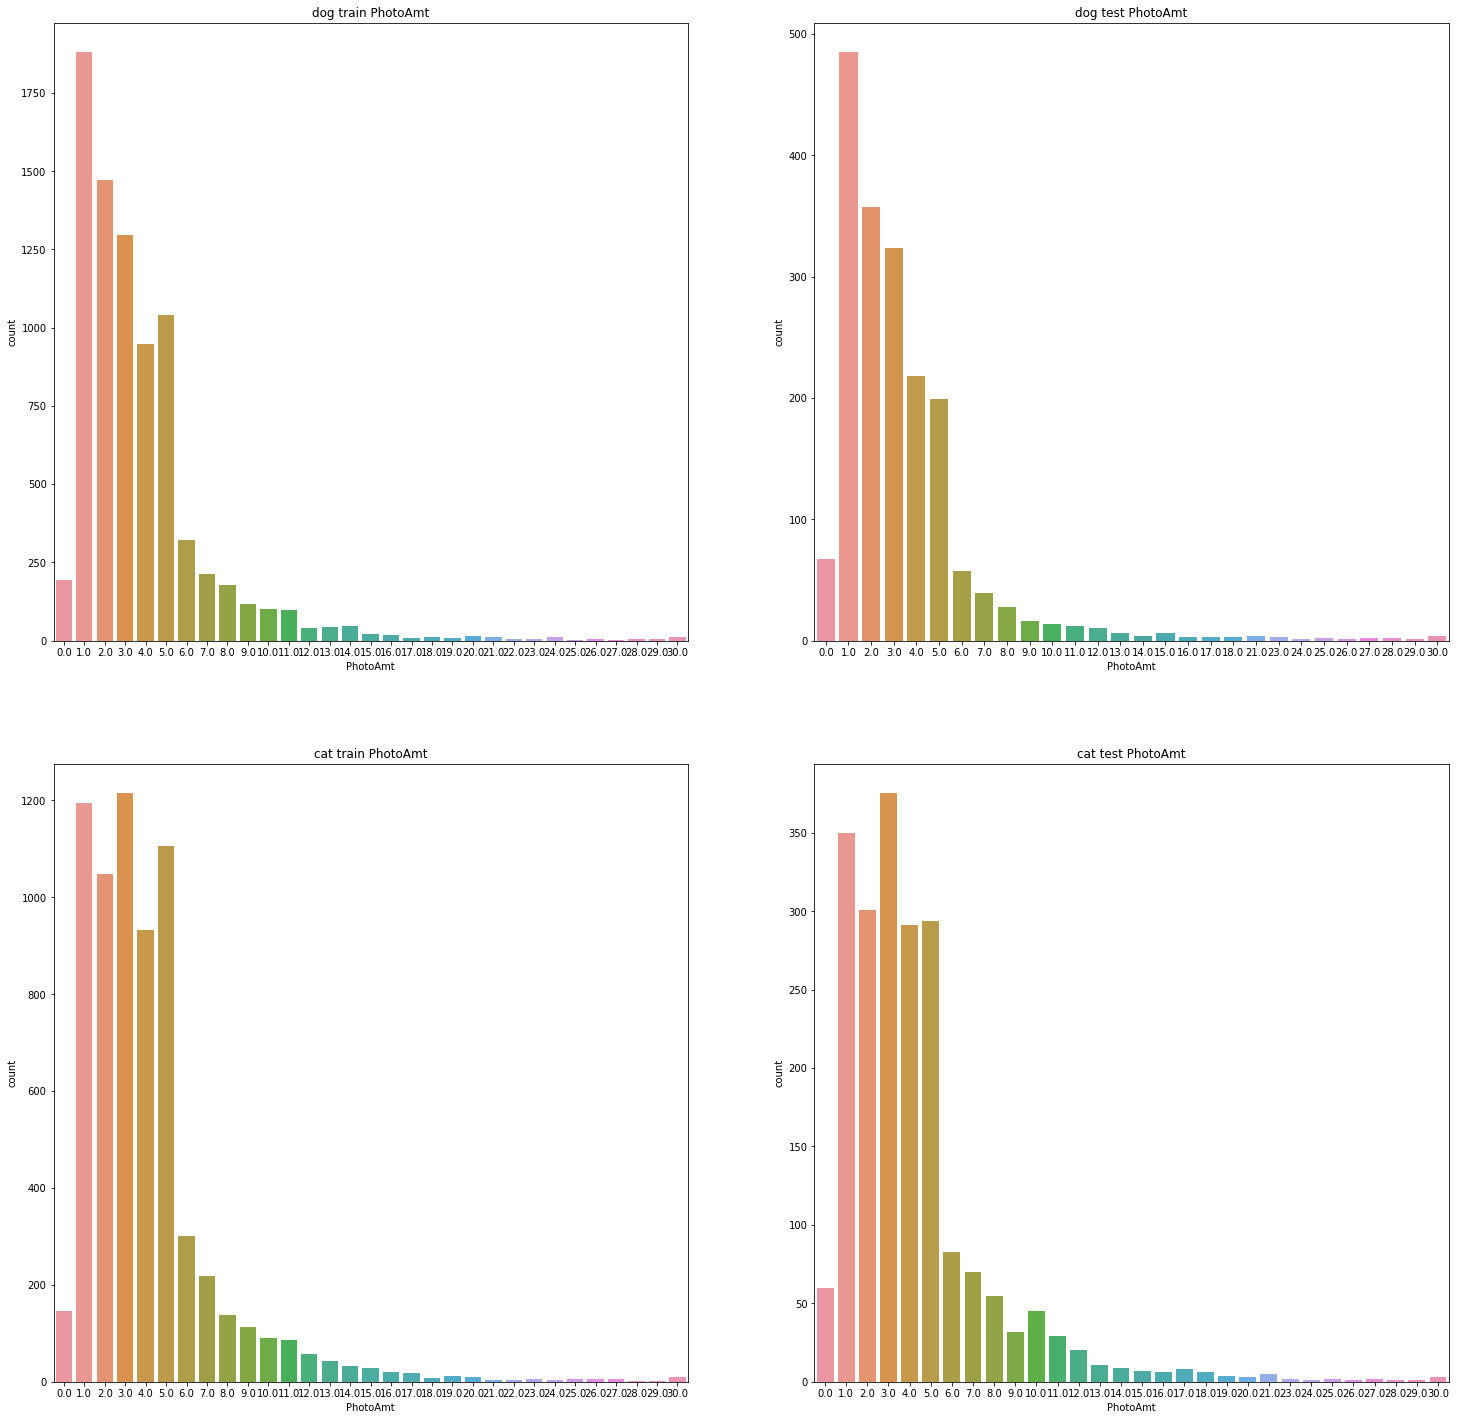

In [85]:
f, ax = plt.subplots(2,2, figsize=(25,25))
dte_h = sns.countplot(dog_train['PhotoAmt'], ax = ax[0,0])
dte_h.set_title('dog train PhotoAmt')
dte_h = sns.countplot(dog_test['PhotoAmt'], ax = ax[0,1])
dte_h.set_title('dog test PhotoAmt')
dte_h = sns.countplot(cat_train['PhotoAmt'], ax = ax[1,0])
dte_h.set_title('cat train PhotoAmt')
dte_h = sns.countplot(cat_test['PhotoAmt'], ax = ax[1,1])
dte_h.set_title('cat test PhotoAmt')

Text(0.5, 1.0, 'Cat PhotoAmt Vs Adoption')

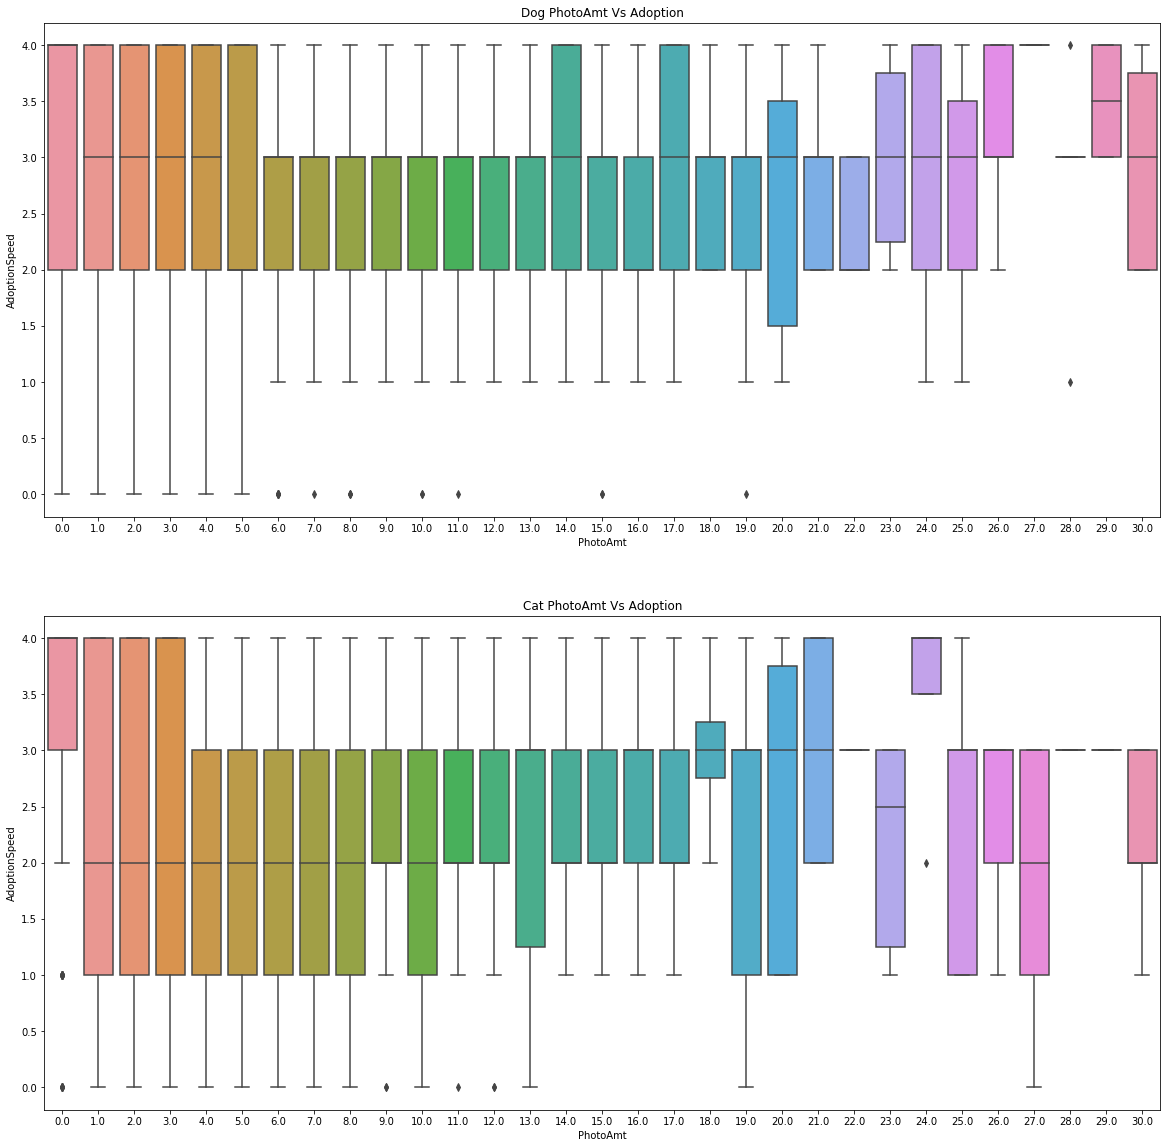

In [91]:
f, ax = plt.subplots(2, figsize= (20,20))

dog_ster = sns.boxplot(x = 'PhotoAmt', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog PhotoAmt Vs Adoption')

cat_ster = sns.boxplot(x = 'PhotoAmt', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat PhotoAmt Vs Adoption')

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cat PhotoAmt Vs Adoption')

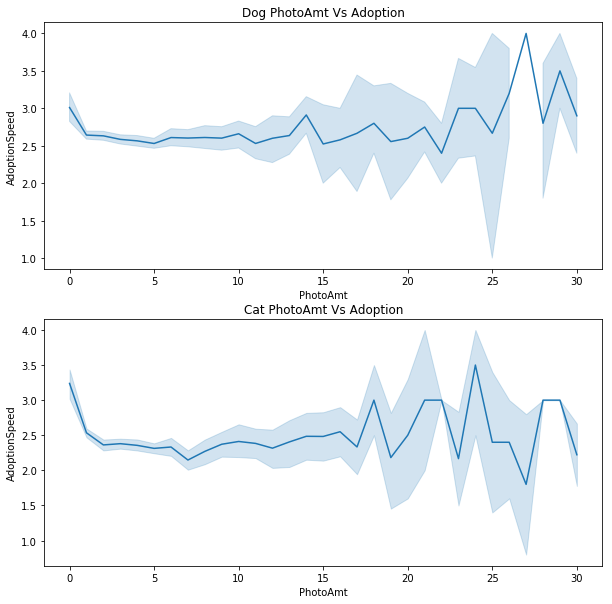

In [89]:
f, ax = plt.subplots(2, figsize= (10,10))

dog_ster = sns.lineplot(x = 'PhotoAmt', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog PhotoAmt Vs Adoption')

cat_ster = sns.lineplot(x = 'PhotoAmt', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat PhotoAmt Vs Adoption')

# VideoAmt

Total videos for this pet


Text(0.5, 1.0, 'cat test VideoAmt')

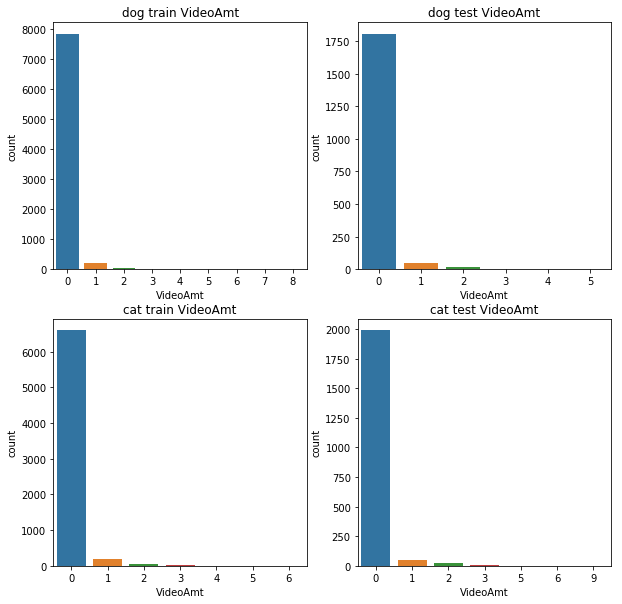

In [93]:
f, ax = plt.subplots(2,2, figsize=(10,10))
dte_h = sns.countplot(dog_train['VideoAmt'], ax = ax[0,0])
dte_h.set_title('dog train VideoAmt')
dte_h = sns.countplot(dog_test['VideoAmt'], ax = ax[0,1])
dte_h.set_title('dog test VideoAmt')
dte_h = sns.countplot(cat_train['VideoAmt'], ax = ax[1,0])
dte_h.set_title('cat train VideoAmt')
dte_h = sns.countplot(cat_test['VideoAmt'], ax = ax[1,1])
dte_h.set_title('cat test VideoAmt')

Text(0.5, 1.0, 'Cat VideoAmt Vs Adoption')

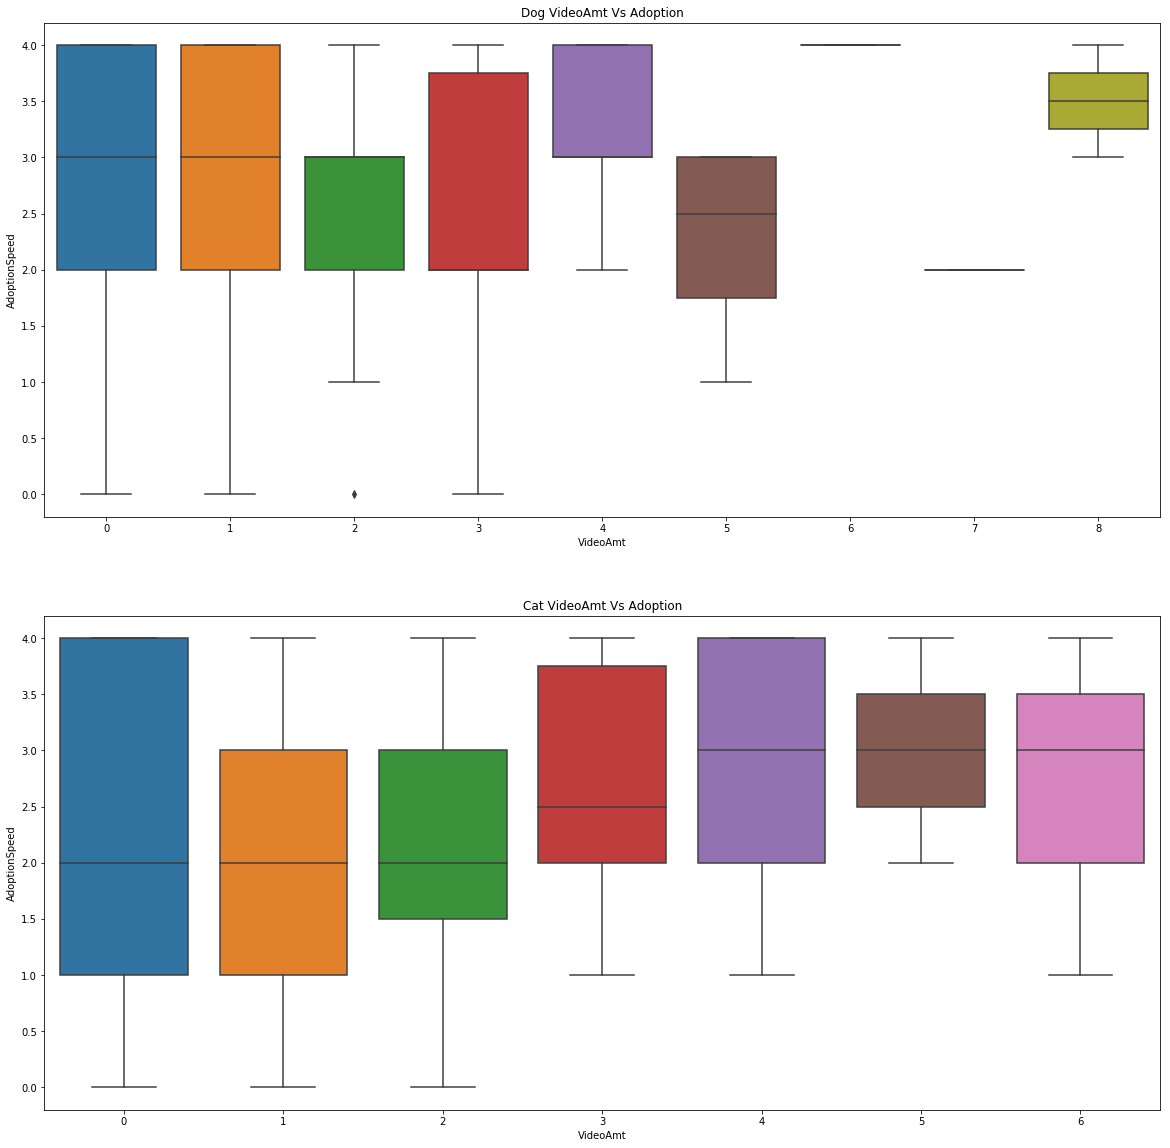

In [94]:
f, ax = plt.subplots(2, figsize= (20,20))

dog_ster = sns.boxplot(x = 'VideoAmt', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog VideoAmt Vs Adoption')

cat_ster = sns.boxplot(x = 'VideoAmt', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat VideoAmt Vs Adoption')

E:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Cat VideoAmt Vs Adoption')

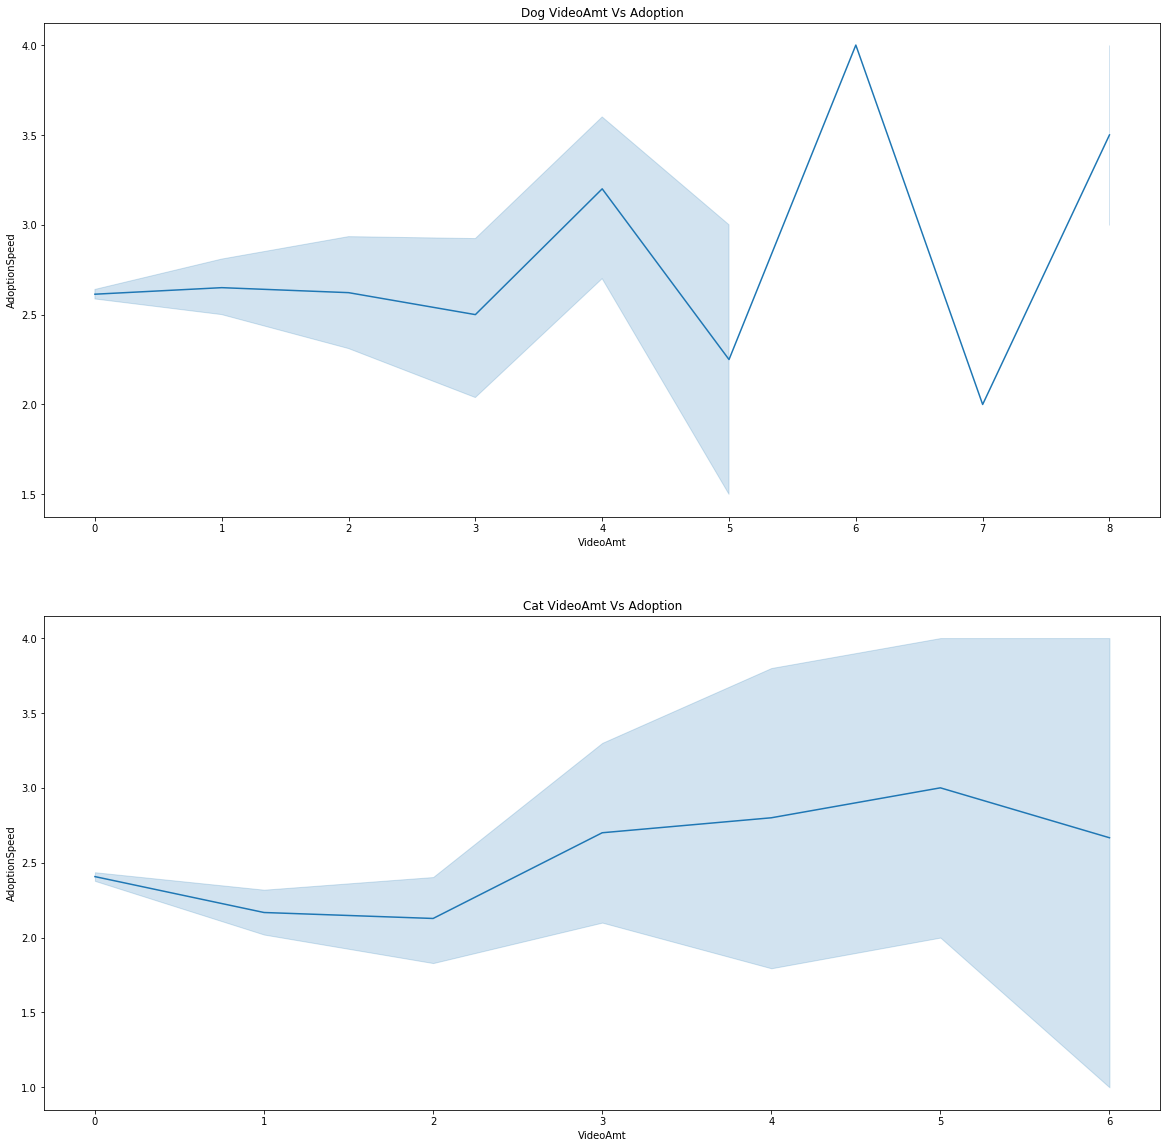

In [95]:
f, ax = plt.subplots(2, figsize= (20,20))

dog_ster = sns.lineplot(x = 'VideoAmt', y = 'AdoptionSpeed', data = dog_train, ax = ax[0])
dog_ster.set_title('Dog VideoAmt Vs Adoption')

cat_ster = sns.lineplot(x = 'VideoAmt', y = 'AdoptionSpeed', data = cat_train, ax = ax[1])
cat_ster.set_title('Cat VideoAmt Vs Adoption')